# Homework 4

## Question 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycaret.time_series import *
import warnings
warnings.filterwarnings('ignore')

### 1. Read the csv file from the URL and set the first column in the data as the index column. 

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/PJalgotrader/Deep_forecasting-USU/main/data/US_macro_Quarterly.csv')
df.set_index(df.columns[0], inplace=True)
df.index.name = 'date'
df.head()

,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
date,,,,,,,,,,,,
1959-03-31,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959-06-30,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959-09-30,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959-12-31,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960-03-31,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


### 2. Before moving forward, we first need to change the data frame index type into "PeriodIndex". Make sure you pick the right frequency for the data?

In [3]:
df.index = pd.to_datetime(df.index).to_period('Q')
df.head()

,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
date,,,,,,,,,,,,
1959Q1,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959Q2,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959Q3,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959Q4,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960Q1,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


### 3. Our variable of interest is "cpi" which stands for consumer price index. Keep this variable in the data and drop the rest.

In [4]:
df = df[['cpi']]
df.head()

,cpi
date,
1959Q1,28.98
1959Q2,29.15
1959Q3,29.35
1959Q4,29.37
1960Q1,29.54


### 4. Using Matplotlib, plot the time series for cpi. Before doing any further investigation, based on what you see, is this time series stationary? What does this imply? Do we need to use differencing here?

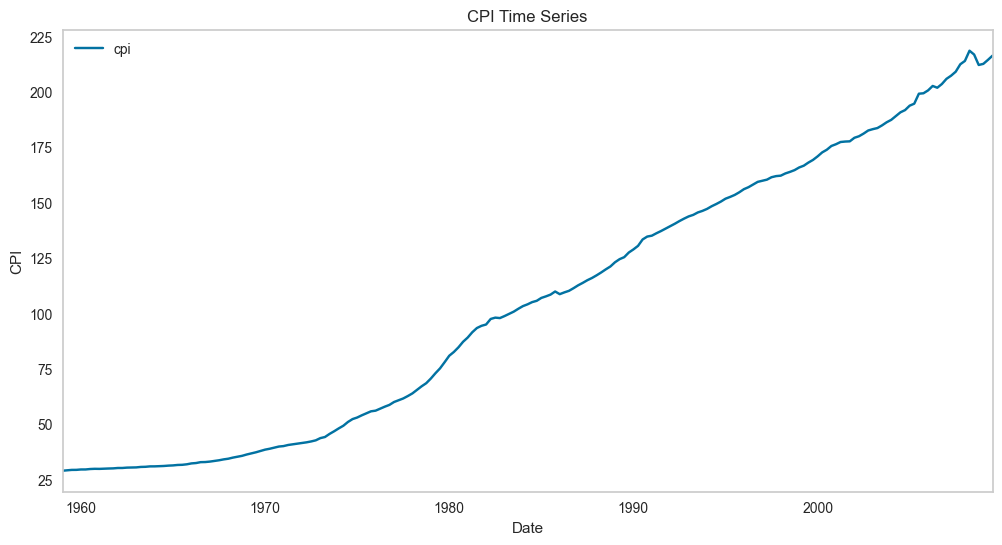

In [5]:
df.plot(figsize=(12,6))
plt.title('CPI Time Series')
plt.grid(visible=False)
plt.xlabel('Date')
plt.ylabel('CPI')
plt.show()

4. (Answer) - This series is not stationary, which means we will need to difference it (if not seasonal, then at least regular differencing).

### 5. Set up your PyCaret experiment with forecasting horizon = 24. How many in-sample observations do you have? How many hold out observations?

In [6]:
exp = TSForecastingExperiment()
exp.setup(data = df, target='cpi' ,  fh = 24, coverage=0.90)

,Description,Value
0,session_id,1833
1,Target,cpi
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(203, 1)"
5,Transformed data shape,"(203, 1)"
6,Transformed train set shape,"(179, 1)"
7,Transformed test set shape,"(24, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


5. (Answer) - There are 179 in-sample observations, and 24 hold-out observations.

### 6. Based on your analysis of the CPI data, which ARIMA model do you think would be the most appropriate? Justify your choice of parameters and explain if there's a need to consider a SARIMA model.

In [7]:
exp.plot_model(plot="diff", data_kwargs={"order_list": [1,2], "acf": True, "pacf": True})

6. (Answer) - I believe ARIMA(1,1,1) would be a good choice, since there appears to be no seasonality (from the original ACF chart), and the first difference is mostly stationary with only the first lag being important in both the ACF and PACF charts. The second difference doesn't appear to provide that much of an improvement over the first difference, so it's probably not worth it.

### 7. Create the following models: (for all the models, set cross_validation=False) 
* ARIMA(1,1,1). Why we are not motivated to try ARMA(p,q) model wit the cpi data? what does this have to do with the ADF test result?
* SARIMA(1,1,1)(0,1,0,4).
* Random walk with drift. Why do you think we don't need to try random walk with no drift for the cpi data?

In [8]:
arima = exp.create_model('arima', order = (1,1,1), seasonal_order=(0,0,0,4), cross_validation=False)
sarima = exp.create_model('arima', order = (1,1,1), seasonal_order=(0,1,0,4), cross_validation=False)
rand_walk = exp.create_model('arima', order = (0,1,0), seasonal_order=(0,0,0,4), cross_validation=False)

,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,2.7906,2.7050,7.3620,8.5104,0.0353,0.0361,0.2681


,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,2.4443,2.3811,6.4486,7.4914,0.0309,0.0316,0.4329


,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,2.8597,2.7581,7.5445,8.6773,0.0362,0.0371,0.2391


7. (Answer) - We don't need to try ARIMA(p,q) because there is obviously a trend in the data, or in other words, the ADF test shows the data is not stationary. And we don't need to try random walk without drift because there is very obviously drift in the data.

### 8. Compare the three models above and say which one has the highest hold-out set R-squared?

In [9]:
exp.compare_models([arima, sarima, rand_walk], cross_validation=False)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
1,ARIMA,2.4443,2.3811,6.4486,7.4914,0.0309,0.0316,0.4329,0.0400
0,ARIMA,2.7906,2.7050,7.3620,8.5104,0.0353,0.0361,0.2681,0.0500
2,ARIMA,2.8597,2.7581,7.5445,8.6773,0.0362,0.0371,0.2391,0.0100


ARIMA(order=(1, 1, 1), seasonal_order=(0, 1, 0, 4))

8. (Answer) - SARIMA had the best R-squared in the holdout set, I guess because it cant hurt to include seasonality, or maybe because the second differencing was, in fact, beneficial.

### 9. Write down the estimated formula for the ARIMA(1,1,1) model.

$y'_t= c+ \phi y'_{t-1} + \theta \epsilon_{t-1} + \epsilon_t$

where $y'_t = y_t - y_{t-1}$

### 10. Plot the in-sample predictions for all the three methods above. Do it in one plot.

In [10]:
exp.plot_model([arima, sarima, rand_walk], plot='insample', data_kwargs={'labels':["ARIMA", "SARIMA", "Random Walk"]})

### 11. Plot the 36-period forecasts for all the three methods above. Do it in one plot.

In [11]:
exp.plot_model([arima, sarima, rand_walk], plot='forecast', data_kwargs={'labels':["ARIMA", "SARIMA", "Random Walk"], 'fh':36})

### 12. Plot the "diagnostics" plot for the ARIMA(1,1,1) model? are the residuals stationary? confirm your answer by reporting the pvalue for the ADF test?

In [12]:
exp.plot_model(arima, plot='diagnostics')

In [13]:
exp.check_stats(arima, test = 'adf')

,Test,Test Name,Data,Property,Setting,Value
0,Stationarity,ADF,Residual,Stationarity,{'alpha': 0.05},True
1,Stationarity,ADF,Residual,p-value,{'alpha': 0.05},0.0
2,Stationarity,ADF,Residual,Test Statistic,{'alpha': 0.05},-6.338795
3,Stationarity,ADF,Residual,Critical Value 1%,{'alpha': 0.05},-3.46828
4,Stationarity,ADF,Residual,Critical Value 5%,{'alpha': 0.05},-2.878202
5,Stationarity,ADF,Residual,Critical Value 10%,{'alpha': 0.05},-2.575653


12. (Answer) - The redisuals do appear to be at least weakly stationary, and the p-value of the ADF test confirms this, since it is reported as 0.0 (which means it is less than 0.0000005, based on the number of digits present in the other reported statistics)

## Question 2

### 1. Create the auto_ets and auto_arima model as two separate models. Again, set the cross_validation = False

In [14]:
auto_ets = exp.create_model('ets', cross_validation=False)
auto_arima = exp.create_model('auto_arima', start_p=0, start_q=0, max_p=5, max_q=5, sp=4, cross_validation=False)

,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,2.8144,2.7095,7.4249,8.5247,0.0356,0.0365,0.2656


,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,2.5156,2.4395,6.6367,7.6752,0.0318,0.0325,0.4047


### 2. Between the three models (auto_arima, auto_ets, ARIMA(1,1,1)) which one is the winner, based on hold-out R-squared? Plot its forecasts for 36 periods ahead.

In [15]:
exp.compare_models([arima, auto_ets, auto_arima], cross_validation=False)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
2,Auto ARIMA,2.5156,2.4395,6.6367,7.6752,0.0318,0.0325,0.4047,2.1100
0,ARIMA,2.7906,2.7050,7.3620,8.5104,0.0353,0.0361,0.2681,0.0500
1,ETS,2.8144,2.7095,7.4249,8.5247,0.0356,0.0365,0.2656,0.0200


AutoARIMA(random_state=1833, sp=4, start_p=0, start_q=0, suppress_warnings=True)

2. (Answer) - The Auto ARIMA model boasts the best R-squared in the hold-out set.

In [16]:
exp.plot_model(auto_arima, plot='forecast', data_kwargs={'fh':36})

### 3. Finalize your auto_arima model (train it with the entire data set) and save it as my_best_model.

In [17]:
final_model = exp.finalize_model(auto_arima)
exp.save_model(final_model, 'my_best_model')

Transformation Pipeline and Model Successfully Saved


(ForecastingPipeline(steps=[('forecaster',
                             TransformedTargetForecaster(steps=[('model',
                                                                 ForecastingPipeline(steps=[('forecaster',
                                                                                             TransformedTargetForecaster(steps=[('model',
                                                                                                                                 AutoARIMA(random_state=1833,
                                                                                                                                           sp=4,
                                                                                                                                           start_p=0,
                                                                                                                                           start_q=0,
                                   

### 4. What is the forecast value for 2025Q1 (this is unseen data) if you use my_best_model?

In [18]:
exp.plot_model(final_model, plot='forecast', data_kwargs={'fh':64})

In [19]:
unseen_predictions = exp.predict_model(final_model, fh=64)
print(f"The predicted value for 2025Q1 is {unseen_predictions.loc['2025Q1','y_pred']:.1f}")

The predicted value for 2025Q1 is 282.9


4. (Answer) - The prediction for 2025Q1 made by the best model is 282.9